<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objetivo es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [ ]:
#!pip uninstall keras
#!pip install tensorflow
#!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:

import re

import numpy as np
import pandas as pd

import tensorflow as tf
#from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import text_to_word_sequence

from keras.layers import Input

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [ ]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [ ]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [ ]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

In [ ]:
all_sentences = input_sentences + output_sentences + output_sentences_inputs

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in all_sentences]

In [ ]:
len(all_sentences)

18099

In [ ]:
all_sentences[0]

'hello '

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

Text(0.5, 1.0, 'Cantidad de palabras por documento')

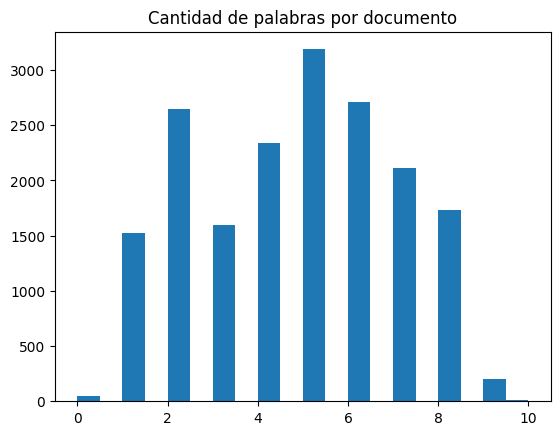

In [ ]:
# podemos ver su distribución
import matplotlib.pyplot as plt
import seaborn as sns

# Se usa para entender que longitud de ventana debe usar el modelo
plt.hist(length_sentences,bins=20)
plt.title('Cantidad de palabras por documento')

In [ ]:
def remove_distinct_words(arrays):
    # Step 1: Find all words and their counts
    word_count = {}

    # Count occurrences of each word
    for array in arrays:
        for sentence in array:
            for word in sentence.split():
                if word in word_count:
                    word_count[word] += 1
                else:
                    word_count[word] = 1

    # Step 2: Create a new list with only non-distinct words
    filtered_arrays = []
    for array in arrays:
        filtered_array = []
        for sentence in array:
            filtered_sentence = ' '.join(word for word in sentence.split() if word_count[word] > 1)
            filtered_array.append(filtered_sentence)
        filtered_arrays.append(filtered_array)

    return filtered_arrays

def count_words(arrays):
    total_word_count = 0
    for array in arrays:
        for sentence in array:
            total_word_count += len(sentence.split())
    return total_word_count

# Remove distinct words
filtered_arrays = remove_distinct_words(all_sentences)

# Count words after removing distinct words
word_count = count_words(filtered_arrays)
print(word_count)

#MAX_VOCAB_SIZE = 8000

MAX_VOCAB_SIZE = word_count

293751


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizador de inglés
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,
                      filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n',
                      #lower=True,
                      #split=' ',
                      char_level=False,
                      oov_token="UNK"
                      #document_count=0
                      )


tokenizer.fit_on_texts(input_sentences + ["<sos>", "<eos>"] + output_sentences_inputs)


input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)


# Obtenemos longitudes máximas de secuencias
max_input_len = max(len(seq) for seq in input_integer_seq)
max_out_len = max(len(seq) for seq in output_integer_seq)

# Convertimos las secuencias a matrices con padding
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len)

# Creamos diccionarios de índices de palabras
word2idx_inputs = tokenizer.word_index
num_words_output = len(tokenizer.word_index) + 1  # +1 por el índice 0
word2idx_outputs = word2idx_inputs  # Como es el mismo idioma, usan el mismo vocabulario

print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in encoder_input_sequences)
print("Sentencia de entrada más larga:", max_input_len)

max_out_len = max(len(sen) for sen in decoder_input_sequences)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2158
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 10


In [ ]:
if '<sos>' not in word2idx_inputs or '<eos>' not in word2idx_inputs:
    print("El token '<sos>' o '<eos>' no está en el vocabulario.")
else:
    print(f"'<sos>' tiene el índice: {word2idx_inputs['<sos>']}")

'<sos>' tiene el índice: 2


In [ ]:
if '<sos>' in word2idx_inputs and '<eos>' in word2idx_inputs:
    print(f"'<sos>' tiene el índice: {word2idx_inputs['<sos>']}")
    print(f"'<eos>' tiene el índice: {word2idx_inputs['<eos>']}")
else:
    print("Error al añadir '<sos>' o '<eos>' al vocabulario.")

'<sos>' tiene el índice: 2
'<eos>' tiene el índice: 1836


In [ ]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

print("encoder_input_sequences shape:", encoder_input_sequences.shape)

print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [ ]:
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 2159)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [ ]:
!pip install gdown

# Descargar el archivo grande desde Google Drive
import gdown

# URL del archivo
url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
output = 'gloveembedding.pkl'

# Descargar el archivo con gdown
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&confirm=t&uuid=df5e7c47-6217-4c57-94b3-4edcbc880e88
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:07<00:00, 69.3MB/s]


'gloveembedding.pkl'

In [ ]:
import pickle

# Cargar el archivo gloveembedding.pkl
with open('gloveembedding.pkl', 'rb') as f:
    glove_embeddings = pickle.load(f)

print("Embeddings cargados correctamente.")

Embeddings cargados correctamente.


In [ ]:
print(glove_embeddings.dtype)  # Ver el tipo de dato y estructura
print(glove_embeddings.shape)  # Ver el tamaño del array

[('word', '<U60'), ('embedding', '<f4', (50,))]
(1193514,)


In [ ]:
for i in range(50,55):
    print(f"Palabra: {glove_embeddings[i]['word']}")
    print(f"Vector: {glove_embeddings[i]['embedding']}\n")

Palabra: o
Vector: [ 0.60109  -0.14074   0.37932   0.27512   0.020188 -0.22858  -0.22028
 -0.069276 -0.23615   0.72592  -0.083696  0.35888  -2.7581    0.2129
 -0.93053  -0.91996  -0.40961  -0.12811  -0.22842  -0.30149   0.3283
  0.80162   0.17914   0.30904   0.44212  -2.2226    0.24192   0.11686
  1.534     0.63024   0.4546    0.096159  0.13848  -0.93412   0.11958
  1.0544   -0.25609  -0.69999  -2.2184    0.52433  -2.7485    0.64835
  0.021584 -0.51248   0.13103   0.1947   -0.17045  -0.25966   0.20723
 -0.87335 ]

Palabra: u
Vector: [ 0.083004  1.0053    0.26507  -0.098562 -0.18409  -0.033368 -0.56497
  0.43791   0.20716   1.288    -0.55683  -0.19672  -4.234    -0.063966
 -0.87323  -0.080305 -0.63516  -0.21967  -0.12525   1.0197    0.20205
  0.19305   0.34885   1.0354    0.16417  -0.60181  -0.097535 -0.2351
  0.1023    0.25122  -0.43261  -0.54675  -0.053332  0.56012   0.91886
  0.19207   0.14778  -0.37423  -0.43194   0.67007  -2.5695    0.53407
  0.65173  -0.15028  -0.18949  -0.31327  

In [ ]:
def buscar_vector(palabra, embeddings):
    resultado = embeddings[embeddings['word'] == palabra]
    if len(resultado) > 0:
        return resultado['embedding'][0]  # Devolver el primer resultado encontrado
    else:
        return None

word ='service'

# Ejemplo de uso
vector_palabra = buscar_vector(word, glove_embeddings)
if vector_palabra is not None:
    print(f"Vector para '{word}': {vector_palabra}")
else:
    print("La palabra no está en los embeddings.")

Vector para 'service': [ 0.60035   0.42985  -1.5568   -0.46131   0.42197   0.098931  0.83017
 -0.56979   0.70937  -1.1017    0.037579  0.019236 -3.4058   -0.049329
  1.0979    0.92937   0.50904   0.24162  -0.69453  -0.15102  -1.1117
 -0.65459  -1.034    -0.36704  -0.16092   0.2334    0.25332  -0.12665
  0.31015   0.19059  -0.40631  -0.86075  -0.33233  -0.53888   1.6453
 -0.055786 -0.30531   0.74686   0.23023  -0.50961  -0.43262   1.1969
 -0.27051   0.10584   0.24776  -0.48772  -0.025647 -0.2543    0.20067
 -0.028146]


In [ ]:
print(f"Dimensionalidad del vector: {glove_embeddings[0]['embedding'].shape}")


Dimensionalidad del vector: (50,)


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    #WORD_MAX_SIZE = 60
    WORD_MAX_SIZE = max_out_len

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    #WORD_MAX_SIZE = 60
    WORD_MAX_SIZE = max_out_len


In [ ]:
# Automatizando generación de dimensionado del embbeding
model_embeddings = GloveEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 45


In [ ]:
embedding_matrix.shape

(2158, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [ ]:
max_input_len

9

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

n_units = 128
dropout_rate = 0.2

# define training encoder
#encoder_inputs = Input(shape=(max_input_len))
# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

#encoder = LSTM(n_units, return_state=True)
encoder = LSTM(n_units, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_35            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_36            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_20 (Embedding)  │ (None, 9, 50)          │        107,900 │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_21 (Embedding)  │ (None, 10, 128)        │        276,352 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_20 (LSTM)            │ [(None, 128), (None,   │         91,648 │ embedding_20[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ [(None, 10, 128),      │        131,584 │ embedding_21[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_20[0][1],         │
│                           │ 128)]                  │                │ lstm_20[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 10, 2159)       │        278,511 │ lstm_21[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 885,995 (3.38 MB)

 Trainable params: 778,095 (2.97 MB)

 Non-trainable params: 107,900 (421.48 KB)

In [ ]:
num_words_output

2159

In [ ]:
#Opcion2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

n_units = 128
dropout_rate = 0.2
# define training encoder
#encoder_inputs = Input(shape=(max_input_len))
# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)
#input_dim = np.max(encoder_input_sequences) + 1
input_dim = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)  # +1 para incluir el índice 0
print('input_dim')
print(input_dim)
encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador  input_dim=nb_words
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
 #encoder = LSTM(n_units, return_state=True)
encoder = LSTM(n_units, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]


# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=50, input_length=max_out_len)
#decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=num_words_output, input_length=max_out_len)

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

input_dim
2159


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_22 (Embedding)  │ (None, 9, 50)          │        107,900 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_23 (Embedding)  │ (None, 10, 50)         │        107,950 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_22 (LSTM)            │ [(None, 128), (None,   │         91,648 │ embedding_22[0][0]     │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_23 (LSTM)            │ [(None, 10, 128),      │         91,648 │ embedding_23[0][0],    │
│                           │ (None, 128), (None,    │                │ lstm_22[0][1],         │
│                           │ 128)]                  │                │ lstm_22[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 10, 2159)       │        278,511 │ lstm_23[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 677,657 (2.59 MB)

 Trainable params: 569,757 (2.17 MB)

 Non-trainable params: 107,900 (421.48 KB)

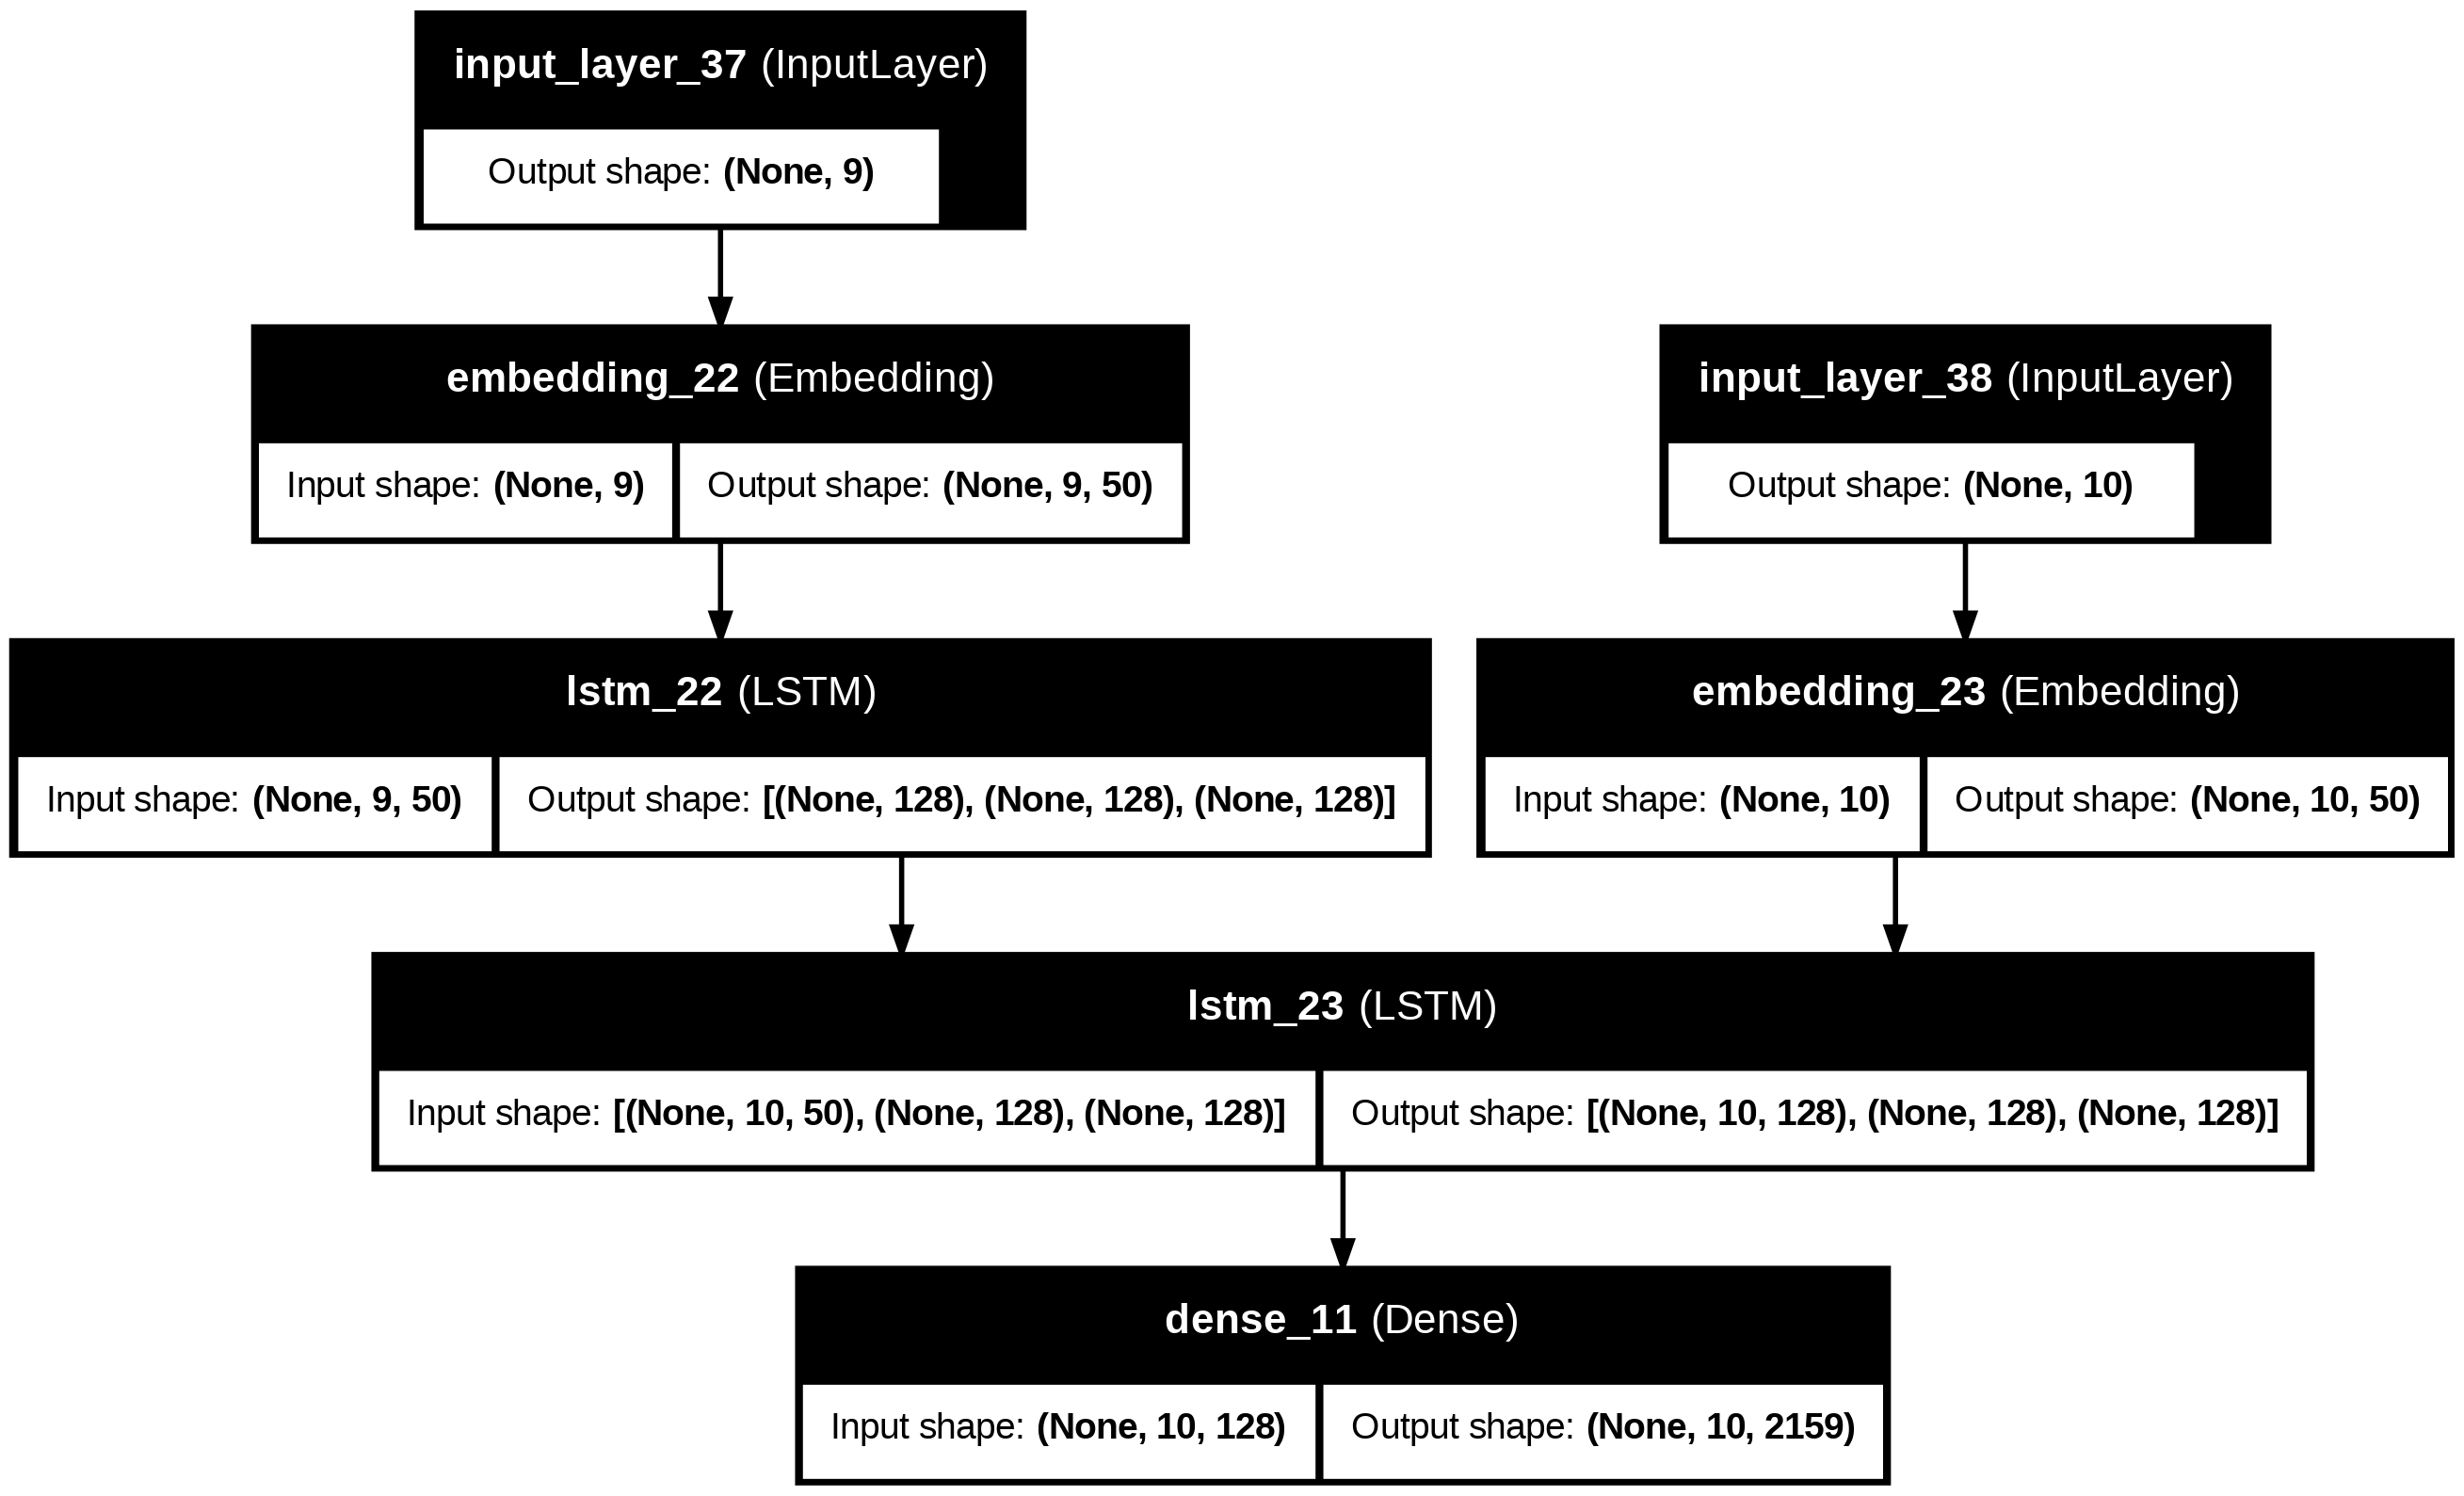

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

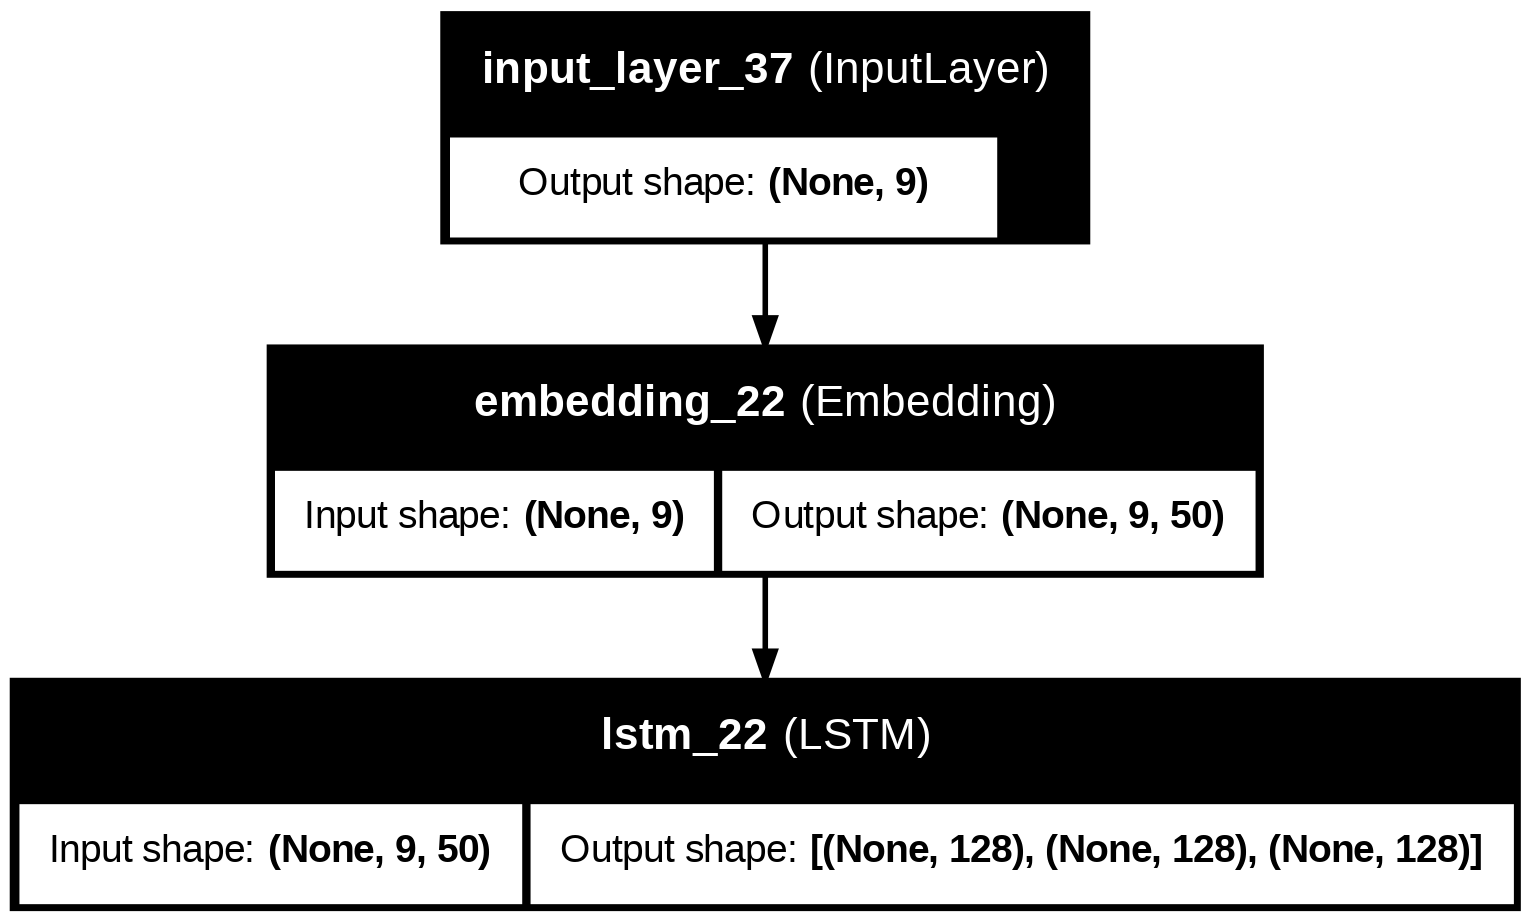

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

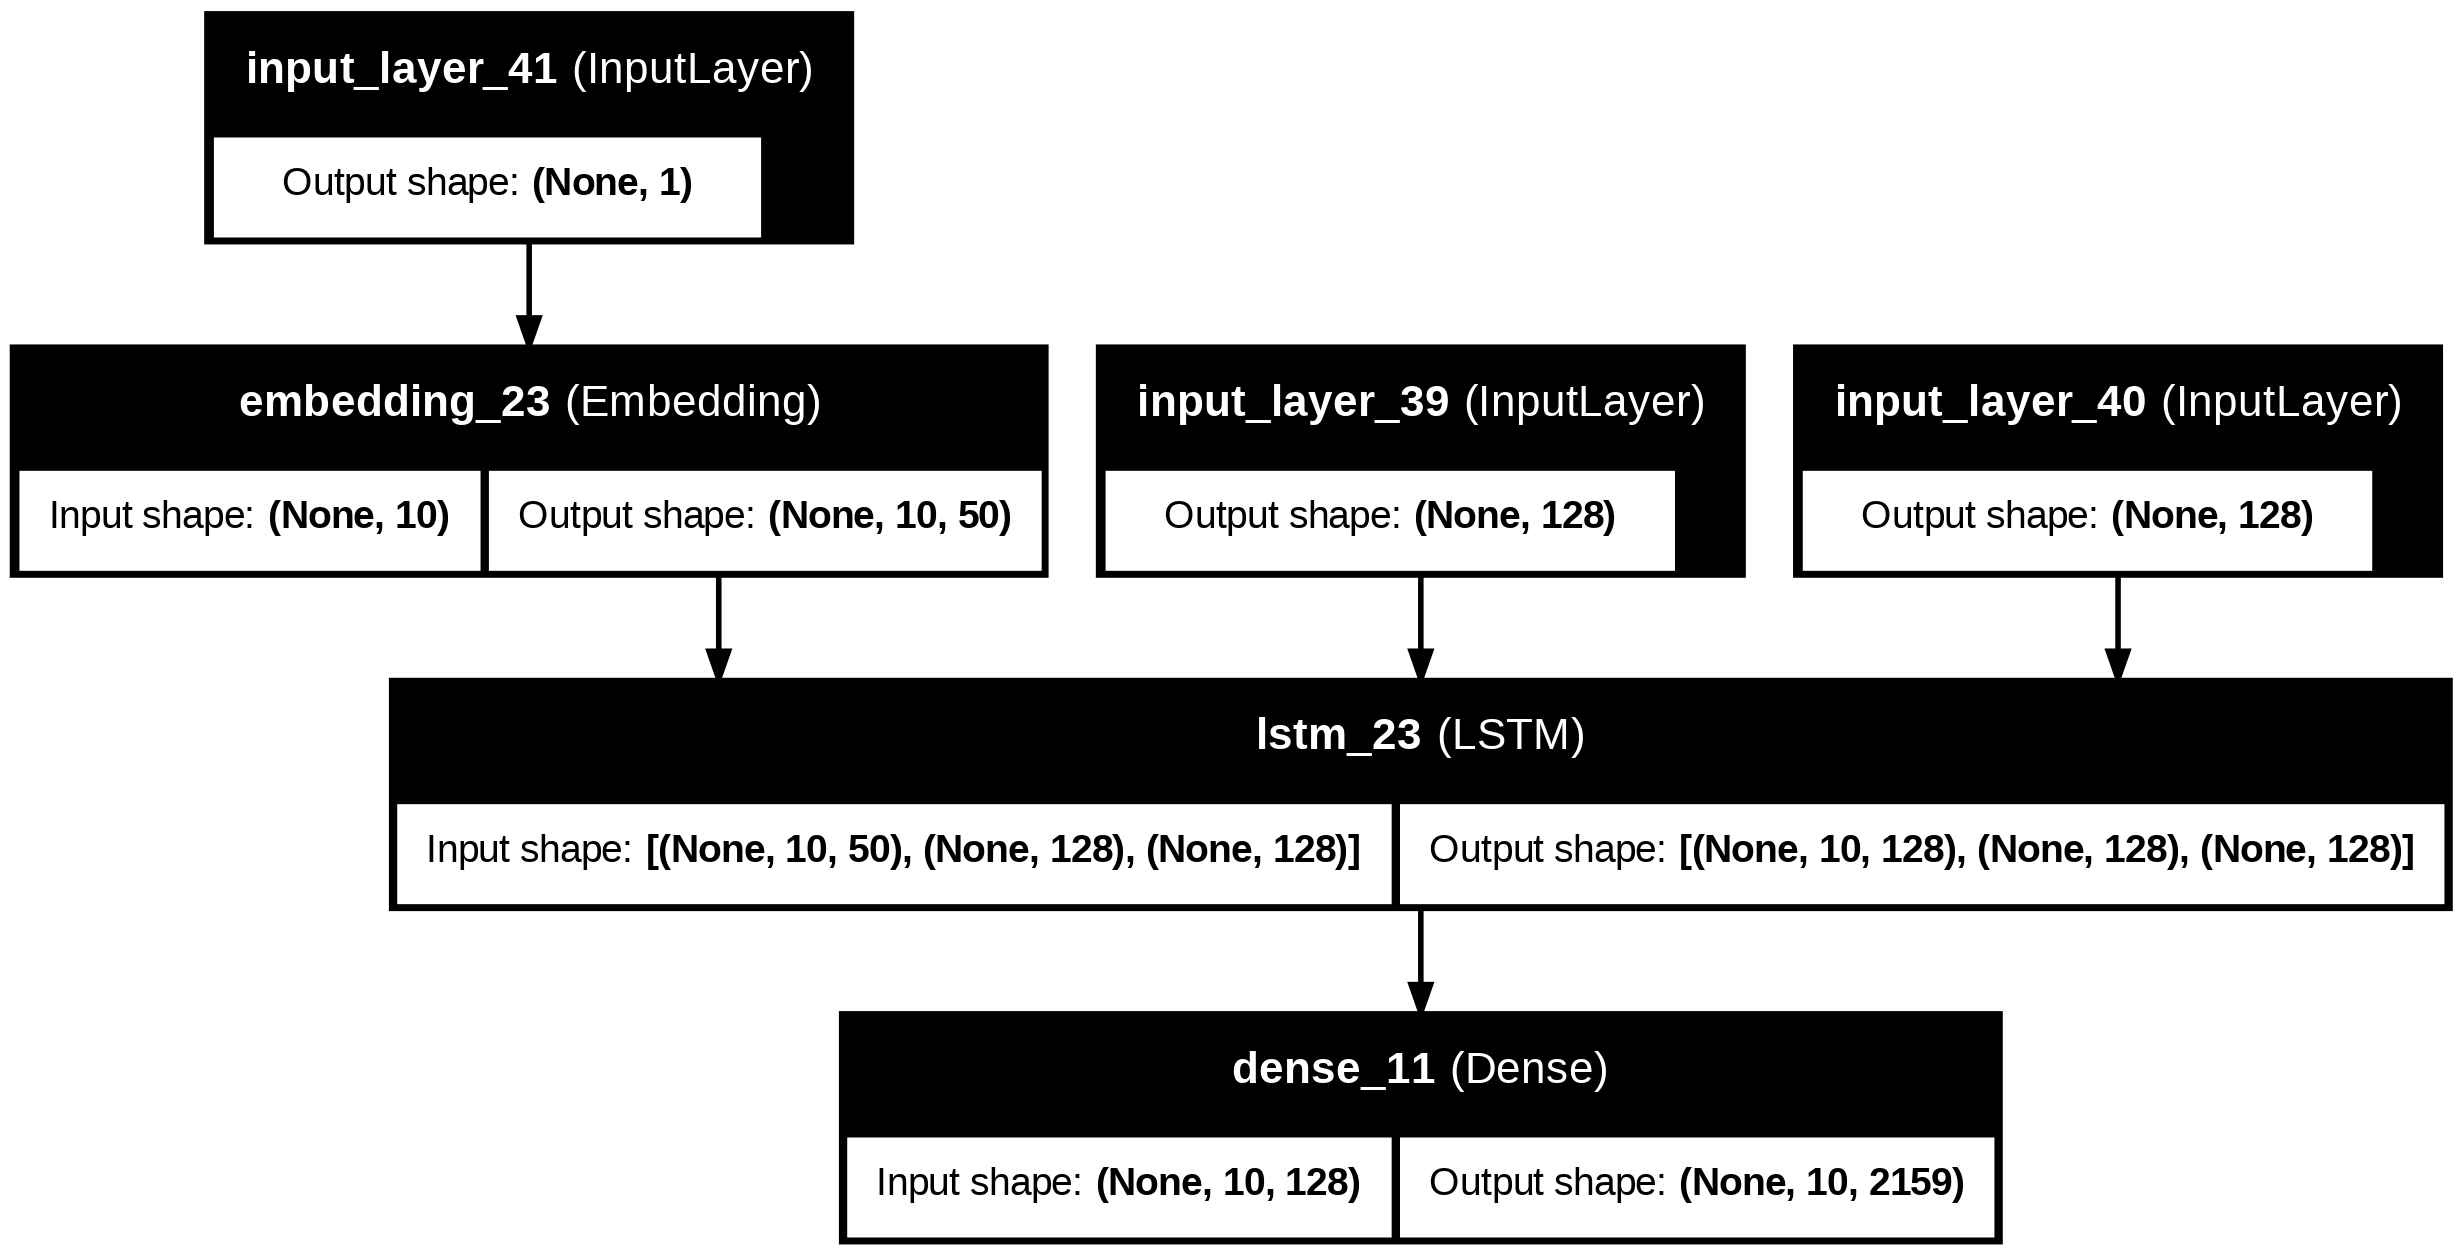

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history_f1 = []

hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2
    #callbacks=[F1Callback([encoder_input_sequences, decoder_input_sequences],decoder_targets,20,history_f1)]
    )

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4691 - loss: 4.5327 - val_accuracy: 0.6083 - val_loss: 2.3275
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6113 - loss: 2.1869 - val_accuracy: 0.6464 - val_loss: 2.1139
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6544 - loss: 1.9211 - val_accuracy: 0.6800 - val_loss: 1.9465
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6933 - loss: 1.7193 - val_accuracy: 0.6939 - val_loss: 1.8201
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7076 - loss: 1.5912 - val_accuracy: 0.7134 - val_loss: 1.7378
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7302 - loss: 1.4871 - val_accuracy: 0.7178 - val_loss: 1.6743
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7418 - loss: 1.3628 - val_accuracy: 0.7257 - val_loss: 1.6338
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7501 - loss: 1.3247 - val_acc

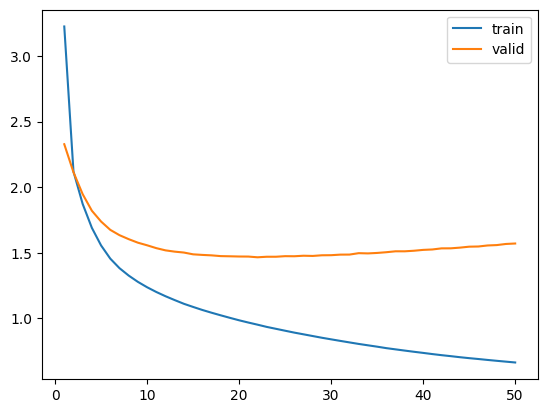

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
# Zero Start:

i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
print(input_seq)
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

[[ 0  0  0  0  0  0  0  0 18]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-
Input: hi
Response: hi what do you do for a living


In [ ]:
# Some Start:

input_test = "What is your name?"

print('Input:', input_test)
integer_seq_test = tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: What is your name?
Representacion en vector de tokens de ids [6, 16, 21, 51]
Padding del vector: [[ 0  0  0  0  0  6 16 21 51]]
Input: What is your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Response: i am a girl i am a girl or
